In [1]:
import pysam
import numpy as np
import math
import click
import pathlib
import matplotlib.pyplot as plt
import click
import json

In [2]:

json_file = '/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/nucleosome_distance/PGDX25573P_WGS_hg19_mrk_nucleosome_distance.json'

# this json file is a dictionary with keys in range(-600, 601) for each distance to a nucleosome
# for each range, the value is a dictionary with the read flags as keys and the counts as values
with open(json_file, "r") as f:
    # load the dictionary from the file
    nuc_dict = json.load(f)



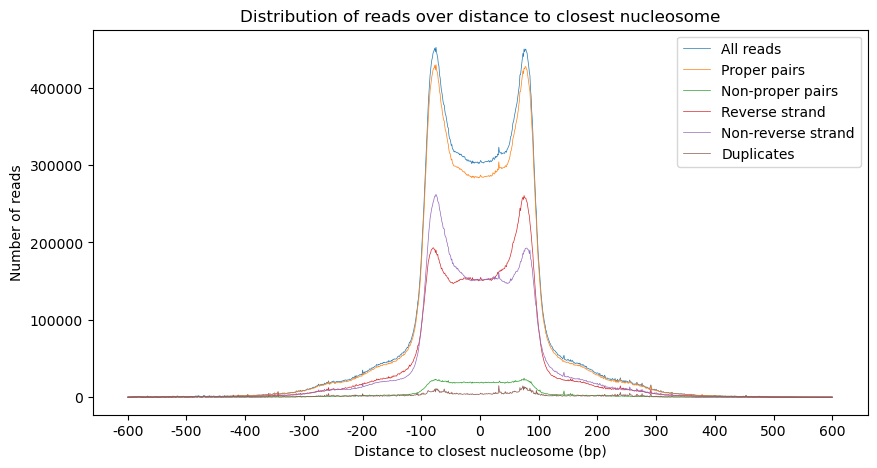

In [39]:
plt.figure(figsize=(10, 5))

# first, plot the total distribution by summing over all the counts for each distance
# this is the same as the histogram that was saved in the previous script
counts_per_distance = np.zeros(1201)
for dist in nuc_dict.keys():
    counts_per_distance[int(dist)+600] = sum(nuc_dict[dist].values())

plt.plot(counts_per_distance, linewidth=0.5)
# set title and labels
plt.title('Distribution of reads over distance to closest nucleosome')
plt.xlabel('Distance to closest nucleosome (bp)')
plt.ylabel('Number of reads')

# now plot the distribution for proper pairs only in the same figure
# first filter the dictionary for only proper pairs using bitwise AND with 0x2 for each distance
proper_pairs_dict = {}
for dist in nuc_dict.keys():
    proper_pairs_dict[dist] = {key: value for key, value in nuc_dict[dist].items() if int(key) & 0x2}

# then sum over all the counts for each distance
proper_pair_counts = np.zeros(1201)
for dist in proper_pairs_dict.keys():
    proper_pair_counts[int(dist)+600] = sum(proper_pairs_dict[dist].values())

plt.plot(proper_pair_counts, linewidth=0.5)

# plot the distribution of everything minus the proper pairs
non_proper_pair_counts = counts_per_distance - proper_pair_counts
plt.plot(non_proper_pair_counts, linewidth=0.5)

# now plot the distribution for reverse strand reads only in the same figure
# first filter the dictionary for only reverse strand reads using bitwise AND with 0x10 for each distance
reverse_strand_dict = {}
for dist in nuc_dict.keys():
    reverse_strand_dict[dist] = {key: value for key, value in nuc_dict[dist].items() if int(key) & 0x10}

# then sum over all the counts for each distance
reverse_strand_counts = np.zeros(1201)
for dist in reverse_strand_dict.keys():
    reverse_strand_counts[int(dist)+600] = sum(reverse_strand_dict[dist].values())

plt.plot(reverse_strand_counts, linewidth=0.5)

# plot the distribution of all the non-reverse strand reads
non_reverse_strand_counts = counts_per_distance - reverse_strand_counts
plt.plot(non_reverse_strand_counts, linewidth=0.5)

# now plot the distribution for duplicate reads only in the same figure
# first filter the dictionary for only duplicate reads using bitwise AND with 0x400 for each distance
duplicate_dict = {}
for dist in nuc_dict.keys():
    duplicate_dict[dist] = {key: value for key, value in nuc_dict[dist].items() if int(key) & 0x400}

# then sum over all the counts for each distance
duplicate_counts = np.zeros(1201)
for dist in duplicate_dict.keys():
    duplicate_counts[int(dist)+600] = sum(duplicate_dict[dist].values())

plt.plot(duplicate_counts, linewidth=0.5)

plt.legend(['All reads', 'Proper pairs', 'Non-proper pairs', 'Reverse strand', 'Non-reverse strand', 'Duplicates'])

# replace the x axis ticks with the distance to the closest nucleosome
plt.xticks(np.arange(0, 1201, 100), np.arange(-600, 601, 100))
plt.show()

In [ ]:
counts = {}
for json_file in pathlib.Path('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/nucleosome_distance/').glob('*.json'):
    with open(json_file, "r") as f:
        # load the dictionary from the file
        nuc_dict = json.load(f)
    counts[json_file.stem.split('_')[0]] = np.zeros(1201)
    for dist in nuc_dict.keys():
        counts[json_file.stem.split('_')[0]][int(dist)+600] = sum(nuc_dict[dist].values() )


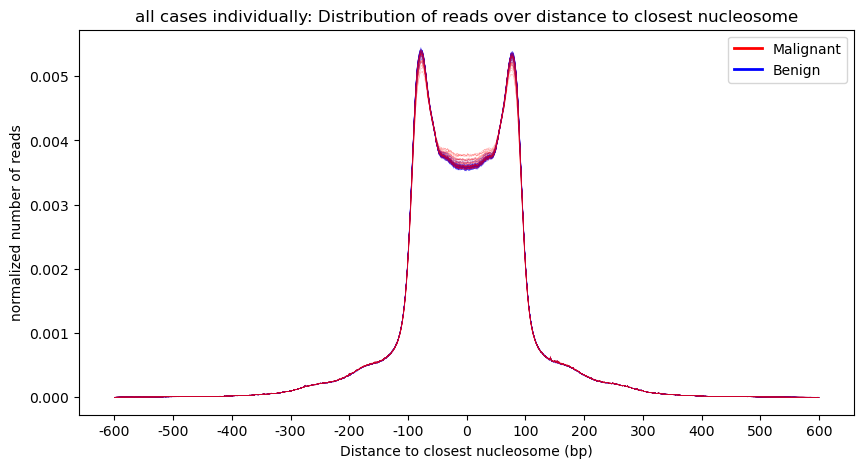

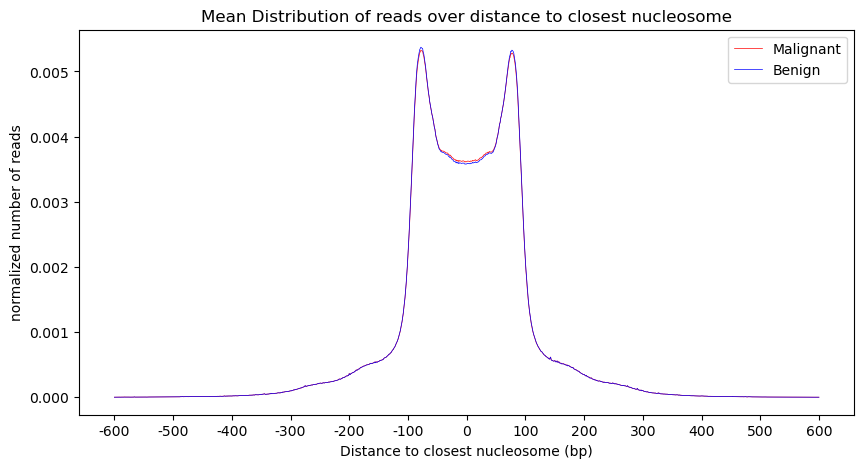

In [41]:
# for each json file in the directory, extract the counts for each distance
# then get the case id from the file name and connect it to a label (malignant or benign from /home/d.gaillard/paired_ovarian/label_data/labels.csv with headers PGDXID,Patient_ID_2,Patient_ID_1,Lesion_Type where we want to use PGDXID and Lesion_Type)
# then plot the distribution for each case in the same figure with a different color

# first, get the labels
labels = {}
with open('/home/d.gaillard/paired_ovarian/label_data/labels.csv', 'r') as f:
    for line in f:
        # skip the header
        if line.startswith('PGDXID'):
            continue
        line = line.strip().split(',')
        labels[line[0]] = line[3]

# then, get the counts and labels for each case, filtering duplicates using bitwise NOT AND with 0x400
counts = {}
for json_file in pathlib.Path('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/nucleosome_distance/').glob('*.json'):
    with open(json_file, "r") as f:
        # load the dictionary from the file
        nuc_dict = json.load(f)
    counts[json_file.stem.split('_')[0]] = np.zeros(1201)
    for dist in nuc_dict.keys():
        counts[json_file.stem.split('_')[0]][int(dist)+600] = sum({key: value for key, value in nuc_dict[dist].items() if not int(key) & 0x400}.values())

# normalize the counts by dividing by the total number of reads
for case in counts.keys():
    counts[case] = counts[case]/sum(counts[case])

# then, plot the counts for each case in the same figure, plotting malignant in red and benign in blue
plt.figure(figsize=(10, 5))
for case in counts.keys():
    if labels[case] == 'Malignant':
        plt.plot(counts[case], linewidth=0.2, color='red', alpha=0.5)
    else:
        plt.plot(counts[case], linewidth=0.2, color='blue', alpha=0.5)

# set title, labels, legend and x axis ticks
plt.title('all cases individually: Distribution of reads over distance to closest nucleosome')
plt.xlabel('Distance to closest nucleosome (bp)')
plt.ylabel('normalized number of reads')

# make the legend for malignant and benign red and blue respectively and without any alpha and a thicker line
legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Malignant'),
                     plt.Line2D([0], [0], color='blue', lw=2, label='Benign')]
plt.legend(handles=legend_elements)
plt.xticks(np.arange(0, 1201, 100), np.arange(-600, 601, 100))
plt.show()

# in a new plot, plot the mean distribution for malignant and benign cases
plt.figure(figsize=(10, 5))
# first, get the average distribution for malignant cases using the counts dictionary by making a new dictionary with only the malignant cases and convert to a numpy array
malignant_counts = {key: value for key, value in counts.items() if labels[key] == 'Malignant'}
malignant_counts = np.array(list(malignant_counts.values()))
benign_counts = {key: value for key, value in counts.items() if labels[key] == 'Benign'}
benign_counts = np.array(list(benign_counts.values()))
# then, get the mean distribution
malignant_mean = np.mean(malignant_counts, axis=0)
benign_mean = np.mean(benign_counts, axis=0)
# then, plot the mean distributions
# malignant in red and benign in blue
# with a thicker line
plt.plot(malignant_mean, linewidth=.5, color='red')
plt.plot(benign_mean, linewidth=.5, color='blue')

# set title, labels, legend and x axis ticks
plt.title('Mean Distribution of reads over distance to closest nucleosome')
plt.xlabel('Distance to closest nucleosome (bp)')
plt.ylabel('normalized number of reads')
plt.legend(['Malignant', 'Benign'])
plt.xticks(np.arange(0, 1201, 100), np.arange(-600, 601, 100))
plt.show()



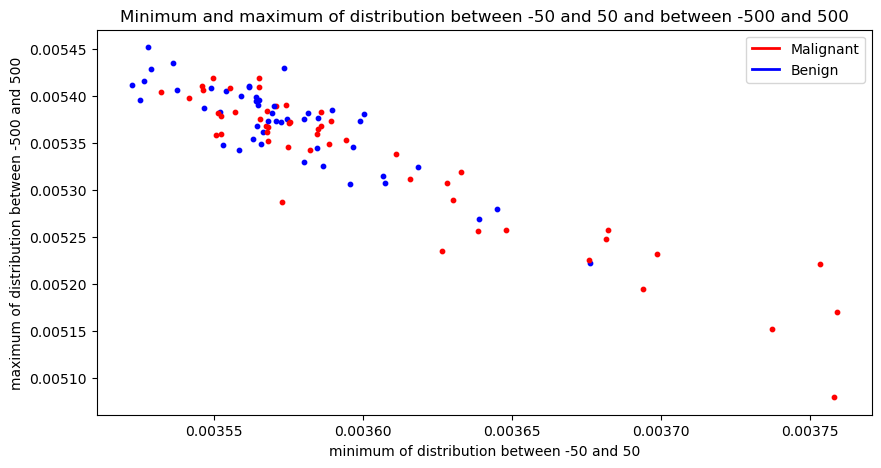

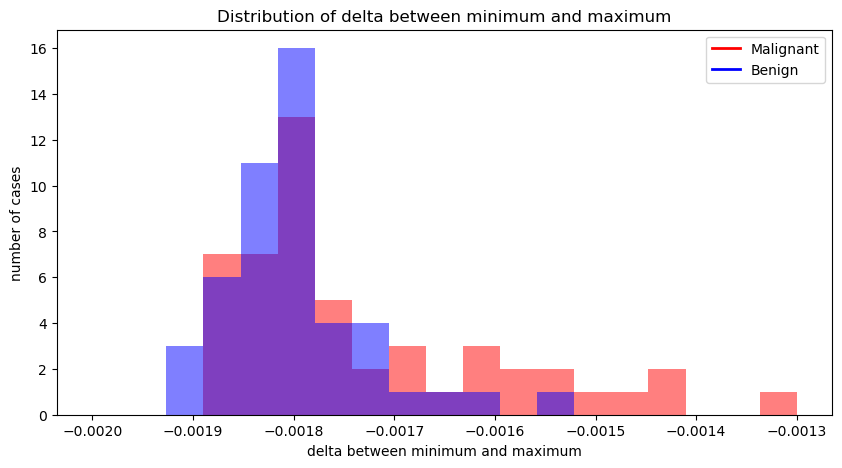

In [65]:
# for each case, calculate the minimum of the distribution between -50 and 50 and calculate the maximum of the distribution between -500 and 500. then, plot the minimum and maximum for each case in a scatter plot with malignant in red and benign in blue

# calculate minimum
minima = {}
for case in counts.keys():
    minima[case] = np.min(counts[case][600-50:600+50])

# calculate maximum
maxima = {}
for case in counts.keys():
    maxima[case] = np.max(counts[case][600-500:600+500])

# plot the minimum and maximum for each case in a scatter plot with malignant in red and benign in blue
plt.figure(figsize=(10, 5))
for case in minima.keys():
    if labels[case] == 'Malignant':
        plt.scatter(minima[case], maxima[case], color='red', s=10)
    else:
        plt.scatter(minima[case], maxima[case], color='blue', s=10)

# set title, labels, legend and x axis ticks
plt.title('Minimum and maximum of distribution between -50 and 50 and between -500 and 500')
plt.xlabel('minimum of distribution between -50 and 50')
plt.ylabel('maximum of distribution between -500 and 500')
# make sure malignant legend is red and benign legend is blue
legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Malignant'),
                        plt.Line2D([0], [0], color='blue', lw=2, label='Benign')]
plt.legend(handles=legend_elements)
plt.show()

# combine into a single number: the number should be high if the minimum is high and the maximum is low, and low if the minimum is low and the maximum is high
# the number is the minimum subtracted by the maximum

# calculate delta and store in maligant and benign numpy arrays and in a dictionary for saving to json
delta = {}
malignant_delta = []
benign_delta = []
for i, case in enumerate(minima.keys()):
    delta[case] = minima[case] - maxima[case]
    if labels[case] == 'Malignant':
        malignant_delta.append(minima[case] - maxima[case])
    else:
        benign_delta.append(minima[case] - maxima[case])

# convert to numpy arrays
malignant_delta = np.array(malignant_delta)
benign_delta = np.array(benign_delta)



# plot the delta for each case in a hist plot with malignant in red and benign in blue
plt.figure(figsize=(10, 5))
bins = np.linspace(-0.002, -0.0013, 20)
plt.hist(malignant_delta, bins=bins, color='red', alpha=0.5)
plt.hist(benign_delta, bins=bins, color='blue', alpha=0.5)

# set title, labels, legend and x axis ticks
plt.title('Distribution of delta between minimum and maximum')
plt.xlabel('delta between minimum and maximum')
plt.ylabel('number of cases')
# make sure malignant legend is red and benign legend is blue
legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Malignant'),
                        plt.Line2D([0], [0], color='blue', lw=2, label='Benign')]
plt.legend(handles=legend_elements)
plt.show()




In [67]:
# save to summary_statistics/nucleosome_delta.json
with open('/home/d.gaillard/paired_ovarian/fragment_lengh_distibution/summary_statistics/nucleosome_delta.json', 'w') as f:
    json.dump(delta, f)